# Amnesty Decode Darfur
Amnesty has an, as of November 10 2016, ongoing project where they ask people to help them identify villages (and/or any humanmade objects) in satellite images. I assume that they will use the labeled images to train a convolutional neural network to do the task automatically later since it's likely going to give the best performance but I figured I'd try to see how well we can do with other methods. I also didn't see an easy way to download all their images so I just had a few of them to work with so training any model would be hard. Instead this is basically just trying to define some rules that could maybe tell apart nature from human made stuff.

TODO: look at http://www.cs.cmu.edu/~skumar/application/kumars_structure.pdf

TODO: generally avoiding task dependent feature extraction is good, but sometimes it's necessary

In [2]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

IMAGE_DIR = "images"

First some example images. Left column are images that do clearly not contain any human made objects like houses. Middle column are images that are easily confused but is still just nature. Third column are images depicting houses or other human made objects that should be labeled as such in the Amnesty project. TODO: amnesty's guideline

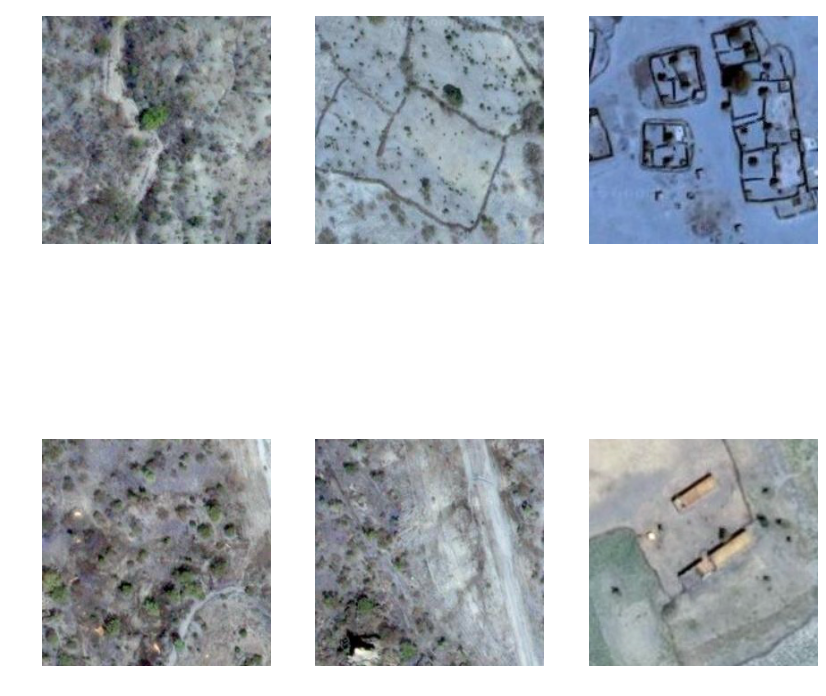

In [3]:
_, axes = plt.subplots(2, 3, figsize=(10, 10))
files = map(lambda fn: os.path.join(IMAGE_DIR, fn), 
            ["nature1.jpg", "nature2.jpg", "close1.jpg", "close2.jpg", "humanmade1.jpg", "humanmade2.jpg"])
for i, fn in enumerate(files):
    r, c = i % 2, i // 2
    axes[r, c].imshow(cv2.imread(fn))
    axes[r, c].axis("off")

Based on some examples of both positive and negative images, we can say that straight lines should be a decent indicator of human made objects. *Hough transform* is a computer vision technique for finding a certain class of shapes  in an image based on a voting procedure of their parametric forms, meaning we can use this to find lines (or ellipses, etc) in the images.

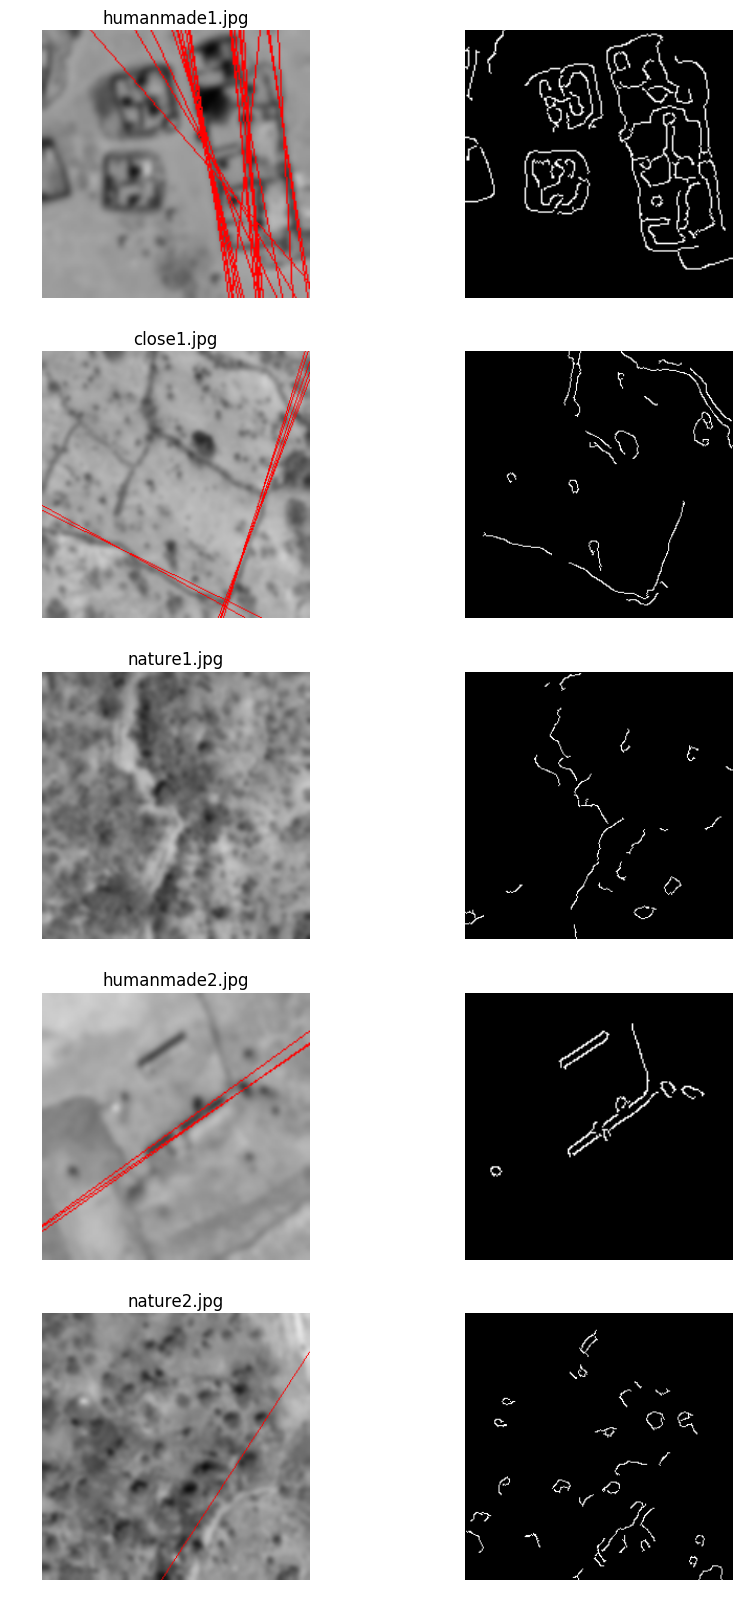

In [10]:
def find_lines(gray_img):
    edges = cv2.Canny(gray_img, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 40)
    line_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
    if isinstance(lines, np.ndarray):
        # Lines represented as polar coordinates
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * -b)
            y1 = int(y0 + 1000 * a)
            x2 = int(x0 - 1000 * -b)
            y2 = int(y0 - 1000 * a)
            cv2.line(line_img, (x1,y1), (x2,y2), (255,0,0), 1)
    
    return line_img, edges
    
files = ["humanmade1.jpg", "close1.jpg", "nature1.jpg", "humanmade2.jpg", "nature2.jpg"]
_, axes = plt.subplots(len(files), 2, figsize=(10, 20))
for i, f in enumerate(files):
    gray_img = cv2.imread(os.path.join(IMAGE_DIR, f), cv2.IMREAD_GRAYSCALE)
    gray_img = cv2.GaussianBlur(gray_img, (11, 11), 0) # Remove small stuff by blurring
    line_img, edges_img = find_lines(gray_img)
    axes[i, 0].imshow(line_img), axes[i, 0].axis("off")
    axes[i, 1].imshow(edges_img, cmap="gray"), axes[i, 1].axis("off")
    axes[i, 0].set_title(f)
    

The problem here seems to be that the lines that the canny edge detector finds are not very straight, so I don't think Hough lines alone are enough for this. Maybe it's possible to play around with the parameters to "denoise" it further but as we can see in *humanmade2.jpg* the radius of the gaussian kernel (that I set for the first image) might have been too big in that image's case ańd we find fewer lines. We also get a spurious line in *nature2.jpg*.

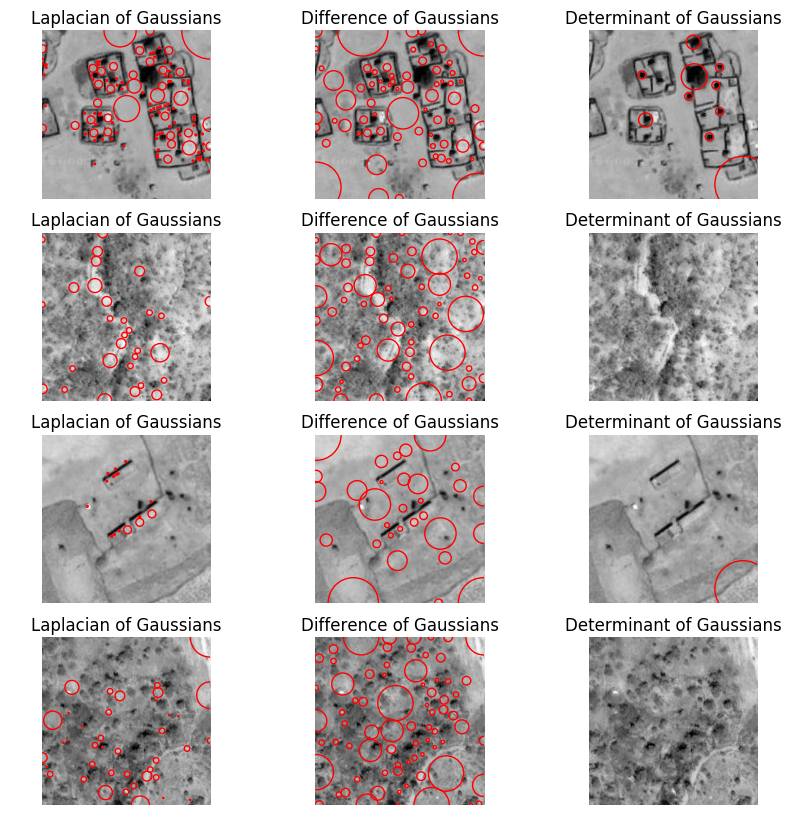

In [12]:
from skimage.feature import blob_dog, blob_doh, blob_log

def plot_blobs(gray_img, axes):    
    b_log = blob_log(gray_img, max_sigma=30, num_sigma=10, threshold=.1)
    b_dog = blob_dog(gray_img, max_sigma=30, threshold=.1)
    b_doh = blob_doh(gray_img)
    
    # Compute radii in third column (from example)
    #b_log[:, 2] *= np.sqrt(2)
    #b_dog[:, 2] *= np.sqrt(2)
    #b_doh[:, 2] *= np.sqrt(2) # TODO: sometimes not present
    
    blobss = [b_log, b_dog, b_doh]
    algs = ["Laplacian of Gaussians", "Difference of Gaussians", "Determinant of Gaussians"]
    
    for blobs, alg, ax in zip(blobss, algs, axes):
        ax.imshow(gray_img, cmap=plt.cm.gray)
        ax.axis("off")
        ax.set_title(alg)
        for y, x, r in blobs:
            c = plt.Circle((x, y), r, color="red", fill=False)
            ax.add_patch(c)

files = ["humanmade1.jpg", "nature1.jpg", "humanmade2.jpg", "nature2.jpg"]
_, axes = plt.subplots(len(files), 3, figsize=(10, 10))
for i, f in enumerate(files):
    gray_img = cv2.imread(os.path.join(IMAGE_DIR, f), cv2.IMREAD_GRAYSCALE)
    plot_blobs(gray_img, axes[i])

This also seems pretty useless,

In [ ]:
# TODO: try template matching? or some kind of home made feature